In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from prometheus_api_client import PrometheusConnect
from math import sqrt
import datetime

2024-03-19 13:10:54.628063: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
PROMETHEUS_URL = 'http://localhost:9090'
PROMETHEUS_ACCESS_TOKEN = ''  

# Initialize Prometheus connection
prom = PrometheusConnect(url=PROMETHEUS_URL, disable_ssl=True)

# Queries
ram_query = '100 - ((avg_over_time(node_memory_MemAvailable_bytes{instance="172.16.101.106:9100",job="kubernetes-service-endpoints"}[5m15s]) * 100) / avg_over_time(node_memory_MemTotal_bytes{instance="172.16.101.106:9100",job="kubernetes-service-endpoints"}[5m15s]))'
cpu_query = '(sum by(instance) (irate(node_cpu_seconds_total{instance="172.16.101.106:9100",job="kubernetes-service-endpoints", mode!="idle"}[5m15s])) / on(instance) group_left sum by (instance)((irate(node_cpu_seconds_total{instance="172.16.101.106:9100",job="kubernetes-service-endpoints"}[5m15s])))) * 100'

In [50]:
def make_query(query, start_days_ago, step):
    end_time = datetime.datetime.now()
    start_time = end_time - datetime.timedelta(days=start_days_ago)
    data = prom.custom_query_range(query=query, start_time=start_time, end_time=end_time, step=step)
    return data

In [55]:
data = make_query(cpu_query, 7, 3000)

In [61]:
len(data[0]["values"])

202

In [3]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i : (i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [21]:
def build_lstm(learning_rate, look_back):
    model = Sequential()
    model.add(LSTM(50, input_shape=(1, look_back), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(25, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate))
    return model

In [32]:
def print_rsme(trainY, testY, trainPredict, testPredict):
    trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
    testScore = sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
    print("Train Score: %.2f RMSE" % (trainScore))
    print("Test Score: %.2f RMSE" % (testScore))

In [22]:
def visualize(df, trainPredict, testPredict, name="value", look_back=3):
    # Visualization
    plt.figure(figsize=(15, 6))
    plt.plot(df["timestamp"], df[name], label="Original Data")
    plt.plot(
        df["timestamp"],
        np.pad(
            trainPredict.ravel(),
            (look_back, len(df) - len(trainPredict) - look_back),
            "constant",
            constant_values=np.nan,
        ),
        label="Train Prediction",
    )
    plt.plot(
        df["timestamp"],
        np.pad(
            testPredict.ravel(),
            (
                len(trainPredict) + 2 * look_back + 1,
                len(df) - len(testPredict) - len(trainPredict) - 2 * look_back - 1,
            ),
            "constant",
            constant_values=np.nan,
        ),
        label="Test Prediction",
    )
    plt.title(f"{name} Prediction")
    plt.xlabel("Timestamp")
    plt.ylabel(name)
    plt.legend()
    plt.show()

In [51]:
def predict(
    prom,
    query,
    name="value",
    start_days_ago=7,
    step="3000",
    look_back=3,
    epochs=1000,
    batch_size=1,
    patience=10,
    learning_rate=0.0005,
):
    data = make_query(query, start_days_ago, step)

    if data:
        timestamps = [
            datetime.datetime.fromtimestamp(float(item[0]))
            for item in data[0]["values"]
        ]
        value = [float(item[1]) for item in data[0]["values"]]

        df = pd.DataFrame(data={"timestamp": timestamps, name: value})
        df["timestamp"] = pd.to_datetime(df["timestamp"])

        # Normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(df[name].values.reshape(-1, 1))


        train_size = int(len(scaled_data) * 0.67)
        test_size = len(scaled_data) - train_size
        train, test = (
            scaled_data[0:train_size, :],
            scaled_data[train_size : len(scaled_data), :],
        )

        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)

        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

        # Build the LSTM model
        model = build_lstm(learning_rate, look_back)

        # Fit the model with early stopping
        early_stop = EarlyStopping(monitor="val_loss", patience=patience, verbose=1)
        history = model.fit(
            trainX,
            trainY,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            validation_data=(testX, testY),
            callbacks=[early_stop],
        )

        # Predictions for training and testing dataset
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)

        # Invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform([trainY])
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform([testY])

        # Calculate RMSE
        print_rsme(trainY, testY, trainPredict, testPredict)
        
        # Function to predict the next 10 days
        def predict_next_10_days(input_data, model, scaler, look_back):
            future_predictions = []
            current_input = input_data[-look_back:].reshape(1, 1, look_back)
            for _ in range(10):  # Predict 10 days into the future
                # Predict the next value
                predicted_value = model.predict(current_input)
                future_predictions.append(scaler.inverse_transform(predicted_value)[0][0])
                
                # Update the current input to include the new prediction
                current_input = np.append(current_input[0, 0, 1:], predicted_value).reshape(1, 1, look_back)
            
            return future_predictions

        # Predict future values
        last_known_data = scaled_data[-look_back:]
        future_predictions = predict_next_10_days(last_known_data, model, scaler, look_back)
        print("Future Predictions:", future_predictions)
        
        # Visualisation
        visualize(df, trainPredict, testPredict, name, look_back)
    else:
        print("No data returned from Prometheus or unexpected data format.")


/Users/william/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 16: early stopping
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train Score: 0.90 RMSE
Test Score: 1.01 RMSE
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Future Predictions: [16.285053, 16.216782, 16.093462, 16.03333, 15.975873, 15.924553, 15.886635, 15.854544, 15.828269, 15.8072815]


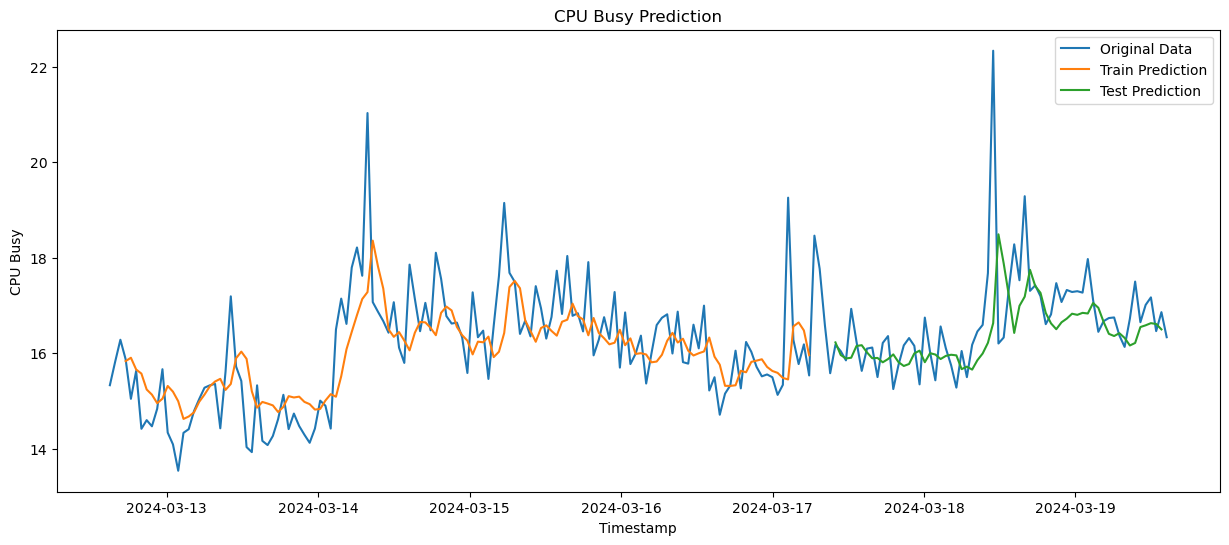

In [53]:
predict(prom, cpu_query, name="CPU Busy", patience=10)

/Users/william/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 21: early stopping
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train Score: 0.46 RMSE
Test Score: 1.94 RMSE
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Future Predictions: [40.45004, 40.27862, 40.036407, 40.855434, 40.967762, 41.16891, 41.497772, 41.688984, 41.907326, 42.133587]


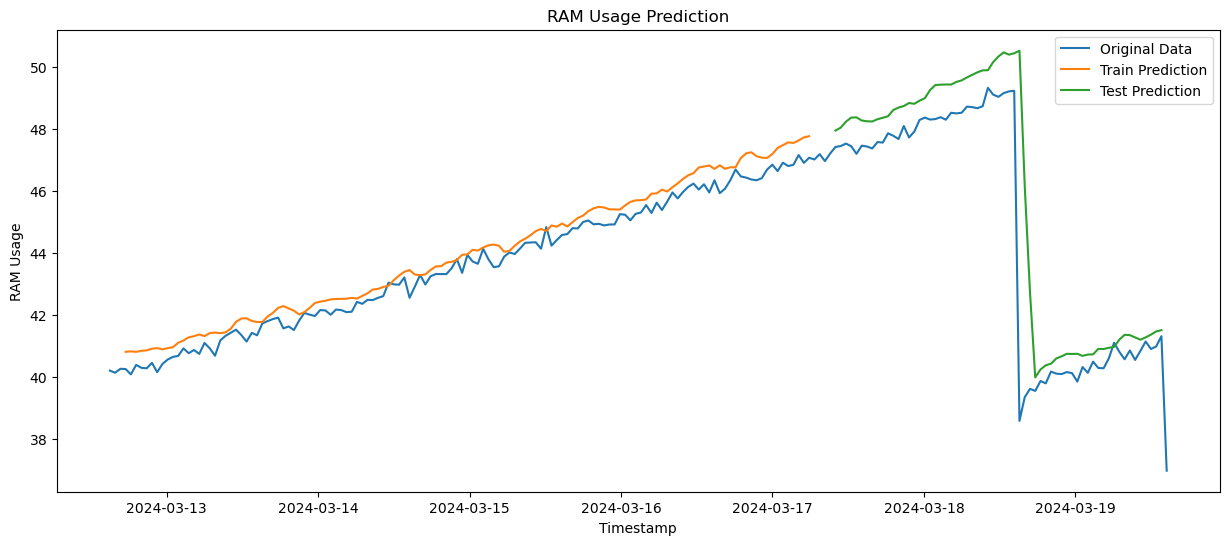

In [54]:
predict(prom, ram_query, name="RAM Usage", patience=10)